In [152]:
import os
import pandas as pd
import numpy as np

import warnings
import itertools
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from scipy.stats import mode

In [153]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [154]:
os.chdir("/.../Chapter 11/Case Study 1 - SMS Classification")
os.getcwd()

'/Users/Dippies/CODE PACKT - EML/Chapter 11/Case Study 1 - SMS Classification'

In [155]:
df_sms = pd.read_csv("sms_labeled_data.csv", encoding = 'utf8')

In [156]:
df_sms.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000..."
4,spam,okmail: Dear Dave this is your final notice to...


In [157]:
df_sms.shape

(5556, 2)

In [158]:
# Gives the count for ham messages
print(df_sms["type"].value_counts()[0])
no_of_ham_messages = df_sms["type"].value_counts()[0]

# Gives the count for spam messages
print(df_sms["type"].value_counts()[1])
no_of_spam_messages = df_sms["type"].value_counts()[1]

4809
747


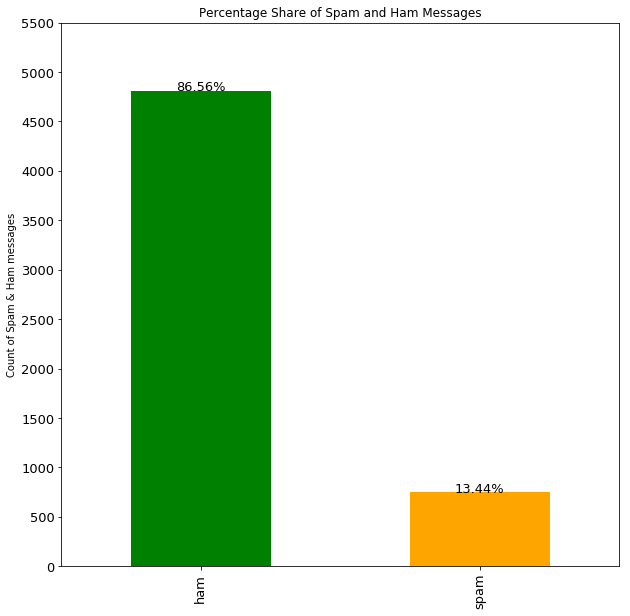

In [159]:
sms_count = pd.value_counts(df_sms["type"], sort= True)
ax = sms_count.plot(kind='bar', figsize=(10,10), color= ["green", "orange"], fontsize=13)

ax.set_alpha(0.8)
ax.set_title("Percentage Share of Spam and Ham Messages")
ax.set_ylabel("Count of Spam & Ham messages");
ax.set_yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500])

totals = []
for i in ax.patches:
    totals.append(i.get_height())
    
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    string = str(round((i.get_height()/total)*100, 2))+'%'
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.16, i.get_height(), string, fontsize=13, color='black')

In [166]:
# Codifying Spam & Ham with 1 & 0
df_sms.loc[df_sms["type"]=='ham',"type",]=1
df_sms.loc[df_sms["type"]=='spam',"type",]=0

### Data Cleaning & Preparation

#### Removing Punctuations, convert text to lowercase and remove stop words

AttributeError: 'str' object has no attribute 'punctuation'

In [179]:
!pip install string

  Could not find a version that satisfies the requirement string (from versions: )
No matching distribution found for string


In [184]:
df_sms.head()

,type,text
0,1,hope good week checking
1,1,kgive back thanks
2,1,also cbe pay
3,0,complimentary 4 star ibiza holiday £10000 cas...
4,0,okmail dear dave final notice collect 4 teneri...


In [182]:
lemmatizer = WordNetLemmatizer()

# Defining a function to remove punctuations, convert text to lowercase and remove stop words
def text_processing(text):
    no_punctuations = [char for char in text if char not in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
    no_punctuations = ''.join(no_punctuations)

    clean_words = [word.lower() for word in no_punctuations.split() if word.lower() not in stopwords.words('english')]
    clean_words = [lemmatizer.lemmatize(lem) for lem in clean_words]
    clean_words = " ".join(clean_words)

    return clean_words

In [183]:
df_sms['text'] = df_sms['text'].apply(text_processing)

In [185]:
df_sms.head()

,type,text
0,1,hope good week checking
1,1,kgive back thanks
2,1,also cbe pay
3,0,complimentary 4 star ibiza holiday £10000 cas...
4,0,okmail dear dave final notice collect 4 teneri...


In [169]:
X = df_sms.loc[:,'text']
Y = df_sms.loc[:,'type']
Y = Y.astype('int')

### Train Test Split

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=1)

### Using the Count Vectorized to convert text to Vectors¶

In [109]:
count_vectorizer = CountVectorizer()

count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [105]:
count_train

<3889x7213 sparse matrix of type '<class 'numpy.int64'>'
	with 51075 stored elements in Compressed Sparse Row format>

### Using the TFidf Count Vectorized to convert text to TFidf Vectors¶

In [106]:
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train)

In [107]:
tfidf_test = tfidf.transform(X_test)

### Fitting a Naive Bayes model (Count Data)

In [192]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()


nb.fit(count_train, Y_train)
nb_pred_train = nb.predict(count_train)
nb_pred_test = nb.predict(count_test)

nb_pred_train_proba = nb.predict_proba(count_train)
nb_pred_test_proba = nb.predict_proba(count_test)

print('The accuracy for the training data is {}'.format(nb.score(count_train, Y_train)))
print('The accuracy for the testing data is {}'.format(nb.score(count_test, Y_test)))
print(accuracy_score(Y_test, nb_pred_test))

The accuracy for the training data is 0.9940858832604783
The accuracy for the testing data is 0.9808038392321535


### Train Statistics (Naive Bayes Model - Count Data)

In [112]:
print(classification_report(Y_train, nb_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       517
           1       1.00      1.00      1.00      3372

   micro avg       0.99      0.99      0.99      3889
   macro avg       0.99      0.99      0.99      3889
weighted avg       0.99      0.99      0.99      3889



508 True Negative 9 False Positive 14 False Negative 3358 True Positive


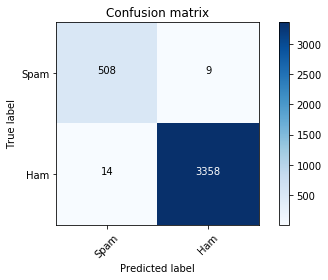

In [122]:
#Check TP,TN,FP,FN
tn, fp, fn, tp = confusion_matrix(Y_train, nb_pred_train).ravel()
print(tn,"True Negative",fp,"False Positive",fn,"False Negative",tp,"True Positive")
target_names = ['Spam','Ham']

#Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_train, nb_pred_train)
plt.figure()
plot_confusion_matrix(cm, classes=target_names)
plt.show()

### Test Statistics (Naive Bayes Model -  Count Data)

In [118]:
print(classification_report(Y_test, nb_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       230
           1       0.99      0.99      0.99      1437

   micro avg       0.98      0.98      0.98      1667
   macro avg       0.96      0.96      0.96      1667
weighted avg       0.98      0.98      0.98      1667



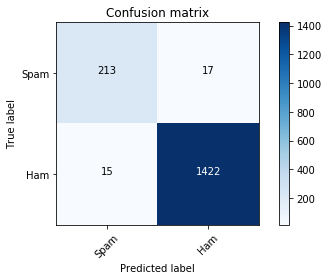

In [195]:
target_names = ['Spam','Ham']

#Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_test, nb_pred_test)
plt.figure()
plot_confusion_matrix(cm, classes=target_names)
plt.show()

### Fitting a Naive Bayes model (TF IDF Train Data)

In [196]:
nb.fit(tfidf_train, Y_train)
nb_pred_train_tfidf = nb.predict(tfidf_train)
nb_pred_test_tfidf = nb.predict(tfidf_test)

nb_tfidf_pred_train_proba = nb.predict_proba(tfidf_train)
nb_tfidf_pred_test_proba = nb.predict_proba(tfidf_test)

print('The accuracy for the training data is {}'.format(nb.score(count_train, Y_train)))
print('The accuracy for the testing data is {}'.format(nb.score(count_test, Y_test)))

The accuracy for the training data is 0.9894574440730265
The accuracy for the testing data is 0.9796040791841631


### Train Statistics (Naive Bayes Model - TF IDF Data)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       517
           1       0.98      1.00      0.99      3372

   micro avg       0.98      0.98      0.98      3889
   macro avg       0.99      0.93      0.96      3889
weighted avg       0.98      0.98      0.98      3889

442 True Negative 75 False Positive 0 False Negative 3372 True Positive


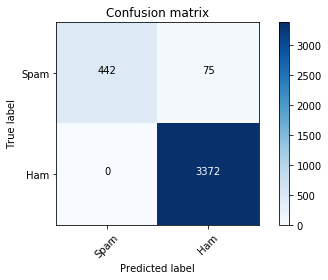

In [130]:
print(classification_report(Y_train, nb_pred_train_tfidf))

#Check TP,TN,FP,FN
tn, fp, fn, tp = confusion_matrix(Y_train, nb_pred_train_tfidf).ravel()
print(tn,"True Negative",fp,"False Positive",fn,"False Negative",tp,"True Positive")
target_names = ['Spam','Ham']

#Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_train, nb_pred_train_tfidf)
plt.figure()
plot_confusion_matrix(cm, classes=target_names)
plt.show()

### Test Statistics (Naive Bayes Model - TF IDF Data)

              precision    recall  f1-score   support

           0       1.00      0.77      0.87       230
           1       0.96      1.00      0.98      1437

   micro avg       0.97      0.97      0.97      1667
   macro avg       0.98      0.88      0.93      1667
weighted avg       0.97      0.97      0.97      1667



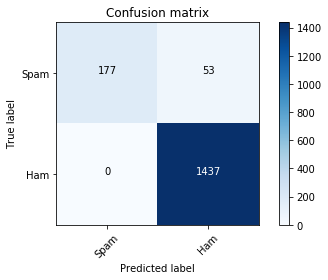

In [197]:
print(classification_report(Y_test, nb_pred_test_tfidf))

target_names = ['Spam','Ham']

#Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_test, nb_pred_test_tfidf)
plt.figure()

plot_confusion_matrix(cm, classes=target_names)
plt.show()

### Fitting an SVM classifier with GridsearchCV with rbf kernel

In [204]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf',probability=True)
svc_params = {'C':[0.001, 0.01, 0.1, 1, 10]}

svc_gcv_rbf_count = GridSearchCV(svc, svc_params, cv=5)
svc_gcv_rbf_count.fit(count_train, Y_train)

# We use the grid model to predict the class 
svc_rbf_train_predicted_values = svc_gcv_rbf_count.predict(count_train)
svc_rbf_test_predicted_values = svc_gcv_rbf_count.predict(count_test)

# We use the grid model to predict the class probabilities
svc_gcv_train_proba_rbf = svc_gcv_rbf_count.predict_proba(count_train)
svc_gcv_test_proba_rbf = svc_gcv_rbf_count.predict_proba(count_test)

print('The best parameters {}'.format(svc_gcv_rbf_count.best_params_))
print('The best score {}'.format(svc_gcv_rbf_count.best_score_))

The best parameters {'C': 10}
The best score 0.8794034456158395


### Train Statistics (SVM RBF Kernel - Count Data)

              precision    recall  f1-score   support

           0       0.99      0.28      0.44       517
           1       0.90      1.00      0.95      3372

   micro avg       0.90      0.90      0.90      3889
   macro avg       0.95      0.64      0.69      3889
weighted avg       0.91      0.90      0.88      3889



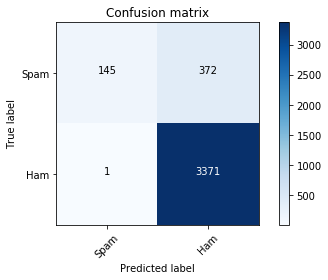

In [205]:
print(classification_report(Y_train, svc_rbf_train_predicted_values))

target_names = ['Spam','Ham']

#Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_train, svc_rbf_train_predicted_values)
plt.figure()
plot_confusion_matrix(cm,classes=target_names)
plt.show()

### Test Statistics (SVM RBF Kernel - Count Data)

              precision    recall  f1-score   support

           0       0.98      0.28      0.43       230
           1       0.90      1.00      0.95      1437

   micro avg       0.90      0.90      0.90      1667
   macro avg       0.94      0.64      0.69      1667
weighted avg       0.91      0.90      0.87      1667



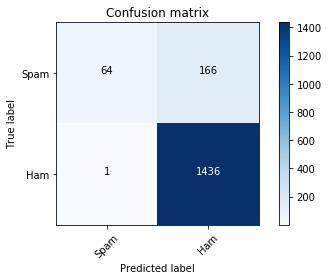

In [206]:
print(classification_report(Y_test, svc_rbf_test_predicted_values))

target_names = ['Spam','Ham']

#Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_test, svc_rbf_test_predicted_values)
plt.figure()
plot_confusion_matrix(cm,classes=target_names)
plt.show()

### Fitting an SVM classifier with GridsearchCV with rbf kernel (TF IDF data)

In [208]:
svc = SVC(kernel='rbf',probability=True)
svc_params = {'C':[0.001, 0.01, 0.1, 1, 10]}

svc_gcv = GridSearchCV(svc,svc_params,cv=5)
svc_gcv.fit(tfidf_train, Y_train)

# We use the grid model to predict the class 
svc_tfidf_rbf_train_predicted_values = svc_gcv.predict(tfidf_train)
svc_tfidf_rbd_test_predicted_values = svc_gcv.predict(tfidf_test)

# We use the grid model to predict the class probabilities
svc_gcv_tfidf_train_proba_rbf = svc_gcv.predict_proba(tfidf_train)
svc_gcv_tfidf_test_proba_rbf = svc_gcv.predict_proba(tfidf_test)

print('The best parameters {}'.format(svc_gcv.best_params_))
print('The best score {}'.format(svc_gcv.best_score_))

The best parameters {'C': 0.001}
The best score 0.8670609411159681


### Train Statistics (SVM RBF Kernel - TF IDF Data)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       517
           1       0.87      1.00      0.93      3372

   micro avg       0.87      0.87      0.87      3889
   macro avg       0.43      0.50      0.46      3889
weighted avg       0.75      0.87      0.81      3889



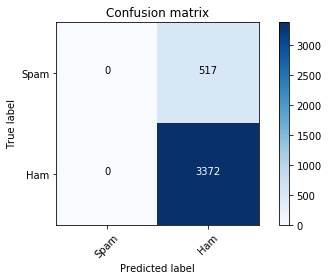

In [217]:
print(classification_report(Y_train, svc_tfidf_rbf_train_predicted_values))

target_names = ['Spam','Ham']

#Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_train, svc_tfidf_rbf_train_predicted_values)
plt.figure()
plot_confusion_matrix(cm,classes=target_names)
plt.show()

### Test Statistics (SVM RBF Kernel - TF IDF Data)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.86      1.00      0.93      1437

   micro avg       0.86      0.86      0.86      1667
   macro avg       0.43      0.50      0.46      1667
weighted avg       0.74      0.86      0.80      1667



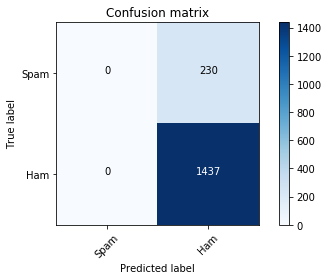

In [209]:
print(classification_report(Y_test, svc_tfidf_rbd_test_predicted_values))


target_names = ['Spam','Ham']

#Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_test, svc_tfidf_rbd_test_predicted_values)
plt.figure()
plot_confusion_matrix(cm,classes=target_names)
plt.show()

### Fitting Random Forest with GridSearchCV to classify (Count Data)


In [212]:
#Set the parameters for grid search
rf_params = {"criterion":["gini","entropy"],"min_samples_split":[2,3],"max_depth":[None,2,3],"min_samples_leaf":[1,5],"max_leaf_nodes":[None],"oob_score":[True]}

#Create an instance of the Random Forest Classifier()
rf = RandomForestClassifier()

#Use gridsearchCV(), pass the values you have set for grid search
rf_gcv = GridSearchCV(rf, rf_params, cv=5)

# Fit the model onto the train data
rf_gcv.fit(count_train, Y_train)

# We use the grid model to predict the class 
rf_train_predicted_values = rf_gcv.predict(count_train)
rf_test_predicted_values = rf_gcv.predict(count_test)

# We use the grid model to predict the class probabilities
rf_gcv_pred_train_proba = rf_gcv.predict_proba(count_train)
rf_gcv_pred_test_proba = rf_gcv.predict_proba(count_test)

print('The best parameters {}'.format(rf_gcv.best_params_))
print('The best score {}'.format(rf_gcv.best_score_))


The best parameters {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'oob_score': True}
The best score 0.9748007199794292


              precision    recall  f1-score   support

           0       0.98      0.79      0.88       230
           1       0.97      1.00      0.98      1437

   micro avg       0.97      0.97      0.97      1667
   macro avg       0.97      0.89      0.93      1667
weighted avg       0.97      0.97      0.97      1667



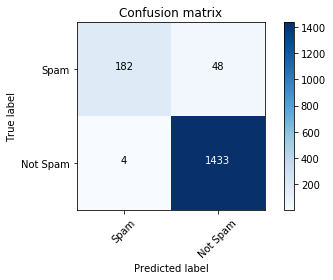

In [215]:
print(classification_report(Y_test, rf_test_predicted_values))

target_names = ['Spam','Ham']

# Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_test, rf_test_predicted_values)
plt.figure()
plot_confusion_matrix(cm,classes=target_names)
plt.show()

### Fitting Random Forest with GridSearchCV to classify (TF-IDF Data)

In [216]:
#Set the parameters for grid search
rf_params = {"criterion":["gini","entropy"],"min_samples_split":[2,3],"max_depth":[None,2,3],"min_samples_leaf":[1,5],"max_leaf_nodes":[None],"oob_score":[True]}


#Create an instance of the Random Forest Classifier()
rf = RandomForestClassifier()

#Use gridsearchCV(), pass the values you have set for grid search
rf_gcv = GridSearchCV(rf, rf_params, cv=5)

rf_gcv.fit(tfidf_train, Y_train)

rf_tfidf_train_predicted_values = rf_gcv.predict(tfidf_train)
rf_tfidf_test_predicted_values = rf_gcv.predict(tfidf_test)

rf_gcv_tfidf_pred_train_proba = rf_gcv.predict_proba(tfidf_train)
rf_gcv_tfidf_pred_test_proba = rf_gcv.predict_proba(tfidf_test)

print('The best parameters {}'.format(rf_gcv.best_params_))
print('The best score {}'.format(rf_gcv.best_score_))


The best parameters {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'oob_score': True}
The best score 0.9737721779377732


              precision    recall  f1-score   support

           0       0.97      0.84      0.90       230
           1       0.98      1.00      0.99      1437

   micro avg       0.98      0.98      0.98      1667
   macro avg       0.98      0.92      0.95      1667
weighted avg       0.98      0.98      0.97      1667



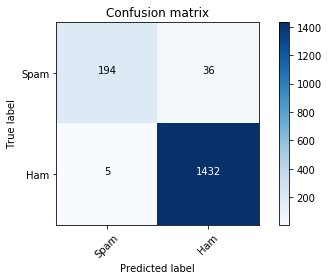

In [219]:
print(classification_report(Y_test, rf_tfidf_test_predicted_values))

target_names = ['Spam','Ham']

#Pass actual & predicted values to the confusion matrix()
cm = confusion_matrix(Y_test, rf_tfidf_test_predicted_values)
plt.figure()
plot_confusion_matrix(cm, classes=target_names)
plt.show()

### Test ROC for all models

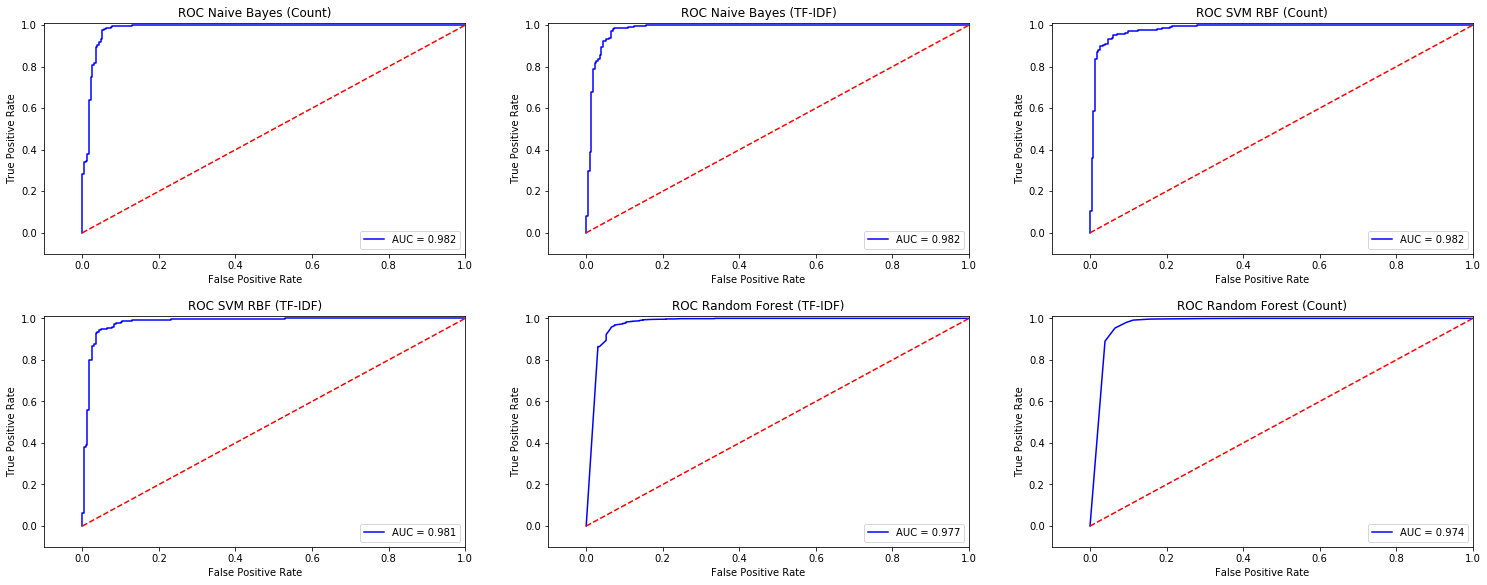

In [230]:
plt.subplot(4,3,1)

fpr, tpr, thresholds = roc_curve(Y_test,nb_pred_test_proba[:,1])
roc_auc = auc(Y_test,nb_pred_test_proba[:,1])

plt.title('ROC Naive Bayes (Count)')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.subplot(4,3,2)

fpr, tpr, thresholds = roc_curve(Y_test,nb_tfidf_pred_test_proba[:,1])
roc_auc = auc(Y_test,nb_tfidf_pred_test_proba[:,1])

plt.title('ROC Naive Bayes (TF-IDF)')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.subplot(4,3,3)

fpr, tpr, thresholds = roc_curve(Y_test,svc_gcv_test_proba_rbf[:,1])
roc_auc = auc(Y_test,svc_gcv_test_proba_rbf[:,1])

plt.title('ROC SVM RBF (Count)')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.subplot(4,3,4)

fpr, tpr, thresholds = roc_curve(Y_test,svc_gcv_tfidf_test_proba_rbf[:,1])
roc_auc = auc(Y_test,svc_gcv_tfidf_test_proba_rbf[:,1])

plt.title('ROC SVM RBF (TF-IDF)')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.subplot(4,3,5)

fpr, tpr, thresholds = roc_curve(Y_test,rf_gcv_pred_test_proba[:,1])
roc_auc = auc(Y_test,rf_gcv_pred_test_proba[:,1])

plt.title('ROC Random Forest (TF-IDF)')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.subplot(4,3,6)

fpr, tpr, thresholds = roc_curve(Y_test,rf_gcv_tfidf_pred_test_proba[:,1])
roc_auc = auc(Y_test,rf_gcv_tfidf_pred_test_proba[:,1])

plt.title('ROC Random Forest (Count)')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.tight_layout(pad=1,rect=(0, 0, 3.5, 4))
plt.show()


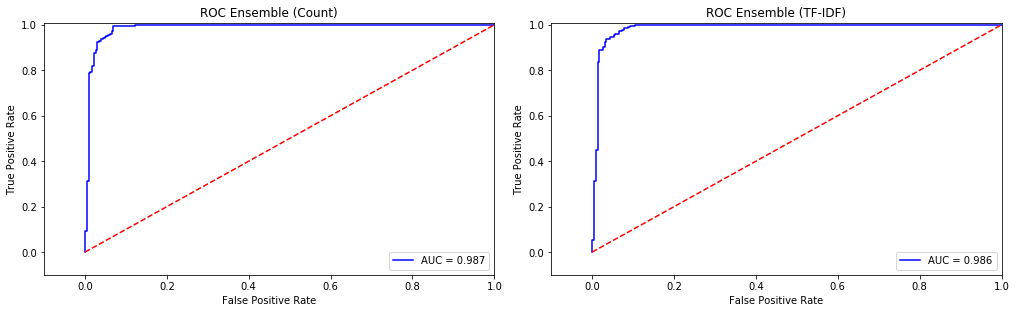

In [242]:
plt.subplot(4,3,7)

### Test Count Data
d = (nb_pred_test_proba + svc_gcv_test_proba_rbf + rf_gcv_pred_test_proba)/4

fpr, tpr, thresholds = roc_curve(Y_test,d[:,1])
roc_auc = auc(Y_test,d[:,1])

plt.title('ROC Ensemble (Count)')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(4,3,8)

### Test TF-IDF Data
d = (nb_tfidf_pred_test_proba + svc_gcv_tfidf_test_proba_rbf + rf_gcv_tfidf_pred_test_proba)/4

fpr, tpr, thresholds = roc_curve(Y_test,d[:,1])
roc_auc = auc(Y_test,d[:,1])

plt.title('ROC Ensemble (TF-IDF)')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()

plt.tight_layout(pad=1,rect=(0, 0, 3.5, 4))
plt.show()


In [255]:
predicted_array = np.array([nb_pred_test_tfidf, svc_tfidf_rbd_test_predicted_values, rf_tfidf_test_predicted_values])

print("Each array is the prediction of the respective models")
print(predicted_array)

Each array is the prediction of the respective models
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [256]:
# Using mode on the array, we get the max vote for each observation
predicted_array = mode(predicted_array)

# Check the array
print(predicted_array)

print("The accuracy for test")
accuracy_score(Y_test, predicted_array[0][0])

ModeResult(mode=array([[1, 1, 1, ..., 1, 1, 1]]), count=array([[3, 3, 3, ..., 3, 3, 3]]))
The accuracy for test


0.9628074385122976

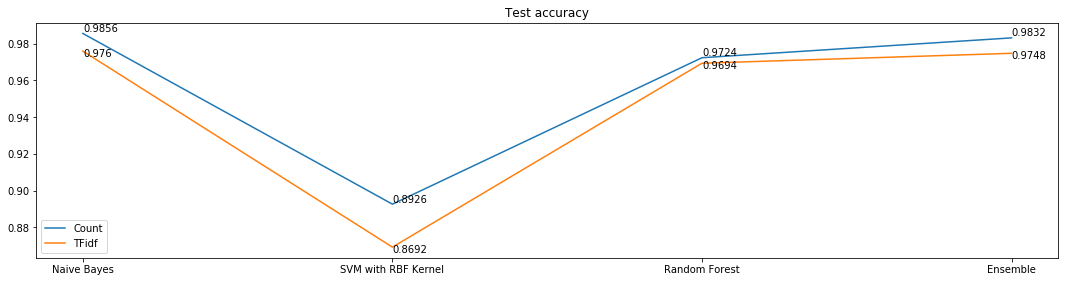

In [261]:
test = np.array([0.9856028794241152,0.8926214757048591,0.9724055188962207,0.9832033593281344])
tfidf = np.array([0.976004799040192,0.8692261547690462,0.9694061187762447,0.9748050389922016])
label_list = ["Naive Bayes","SVM with RBF Kernel","Random Forest","Ensemble"] 
plt.plot(test)
plt.plot(tfidf)
plt.xticks([0,1,2,3],label_list)

for i in range(4):
    plt.text(x=i,y=(test[i]+0.001),s= np.round(test[i],4))

for i in range(4):
    plt.text(x=i,y=tfidf[i]-0.003,s= np.round(tfidf[i],4))

plt.legend(["Count","TFidf"])
plt.title("Test accuracy")

plt.tight_layout(pad=1,rect=(0, 0, 2.5, 1))
plt.show()